## 📑 `KDE plots of post-generation scores for the dataset`

### 🔁 Prerequisites:
1. **Generate datasets first**  
   Produce the outpainted image sets and `datasets/outpainted/outpainted_prompts.csv`, which includes prompts and scores for the generated images:

   ```bash
   python main.py aidovecl
   ```
   <br>

2. **Run captioning & similarity computation**  
   Reads `datasets/outpainted/outpainted_prompts.csv`, generates BLIP and ViT-GPT2 captions for each outpainted image, computes caption–prompt and caption–caption cosine similarities with SentenceTransformers, and saves the results to `datasets/outpainted/semantic_similarities.csv`:

   ```bash
   python main.py prompt_semantics
   ```

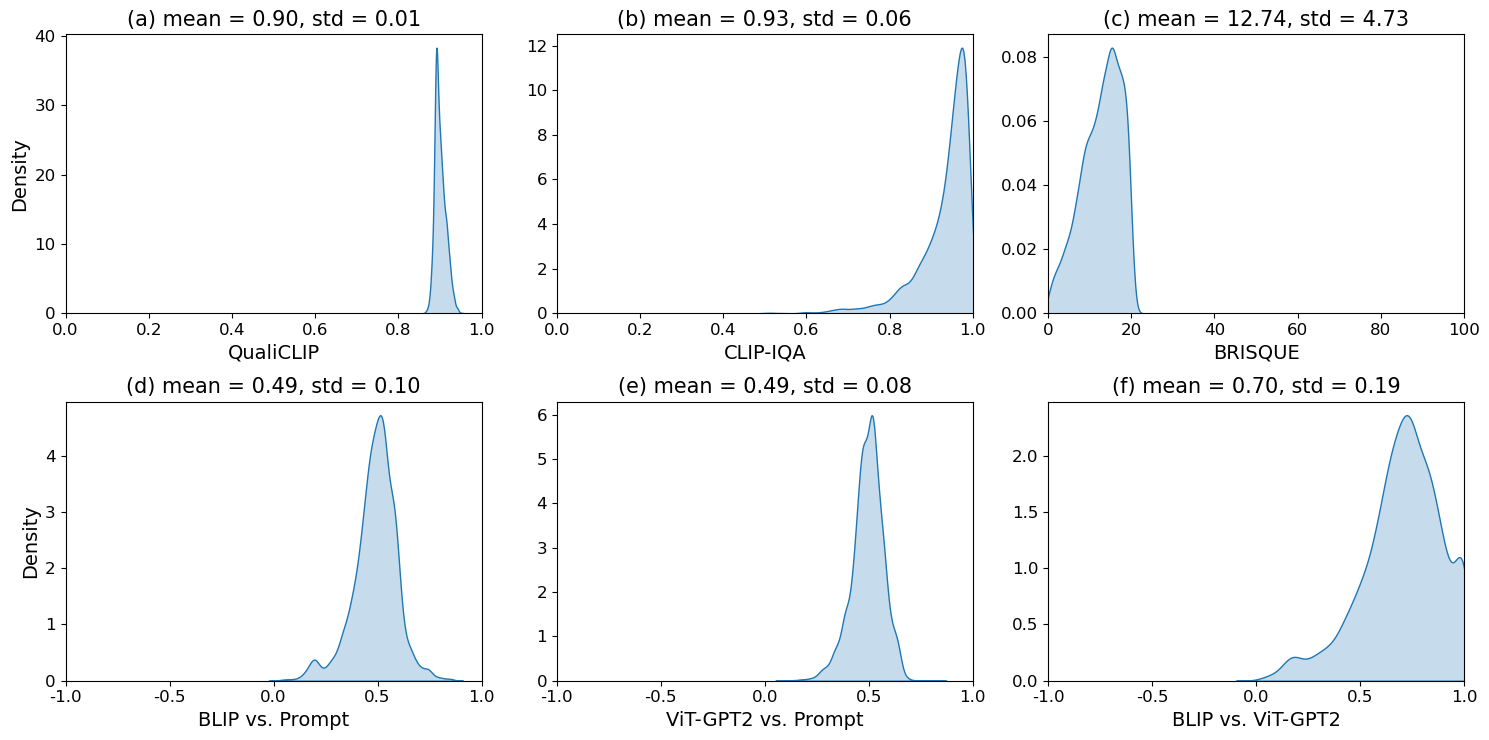

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Increase font sizes globally
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14
})

# Load the first dataset (semantic similarities)
df_sim = pd.read_csv("datasets/outpainted/semantic_similarities.csv")
sim_columns = [col for col in df_sim.columns if "sim" in col]

# Load the second dataset (quality scores)
df_score = pd.read_csv("datasets/outpainted/outpainted_prompts.csv")
score_columns = [col for col in df_score.columns if "score" in col]

# Ensure we have columns to plot
if len(sim_columns) == 0:
    raise ValueError("No columns with 'sim' found in semantic_similarities.csv.")
if len(score_columns) == 0:
    raise ValueError("No columns with 'score' found in outpainted_prompts.csv.")

# Define custom x‐labels (assuming exactly three columns each)
score_labels = ["QualiCLIP", "CLIP-IQA", "BRISQUE"]
sim_labels   = ["BLIP vs. Prompt", "ViT-GPT2 vs. Prompt", "BLIP vs. ViT-GPT2"]

# Determine number of columns (assumes 3 for each group)
n_score = len(score_columns)
n_sim   = len(sim_columns)
n_cols  = max(n_score, n_sim)  # expected to be 3

# Create output directory if it doesn't exist
output_dir = Path("./figs/fig4")
output_dir.mkdir(parents=True, exist_ok=True)

# Create a 2×n_cols subplot figure with height = width/2
fig_width = 5 * n_cols
fig_height = fig_width / 2
fig, axes = plt.subplots(
    2,
    n_cols,
    figsize=(fig_width, fig_height),
    squeeze=False
)

# Generate subplot labels (a), (b), (c), ... for all six plots
base_labels = [f"{chr(97 + i)}" for i in range(n_score + n_sim)]

# X‐tick positions for similarity plots (same for all "sim" axes)
sim_xticks = np.round(np.arange(-1, 1.1, 0.5), 1)

# Plot the quality‐score KDEs in the first row
for idx, col in enumerate(score_columns):
    ax = axes[0, idx]
    data = df_score[col].dropna()
    mean_val = data.mean()
    std_val = data.std()
    sns.kdeplot(data, ax=ax, fill=True)
    title_text = f"({base_labels[idx]}) mean = {mean_val:.2f}, std = {std_val:.2f}"
    ax.set_title(title_text)
    ax.set_xlabel(score_labels[idx])  # custom x‐label
    if idx == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    if "brisque" in col.lower():
        ax.set_xlim(0, 100)
    else:
        ax.set_xlim(0, 1)

# Remove any unused axes in the first row (if n_score < n_cols)
for j in range(n_score, n_cols):
    fig.delaxes(axes[0, j])

# Plot the semantic‐similarity KDEs in the second row
for idx, col in enumerate(sim_columns):
    ax = axes[1, idx]
    data = df_sim[col].dropna()
    mean_val = data.mean()
    std_val = data.std()
    sns.kdeplot(data, ax=ax, fill=True)
    title_index = n_score + idx
    title_text = f"({base_labels[title_index]}) mean = {mean_val:.2f}, std = {std_val:.2f}"
    ax.set_title(title_text)
    ax.set_xlabel(sim_labels[idx])  # custom x‐label
    if idx == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.set_xlim(-1, 1)
    ax.set_xticks(sim_xticks)
    ax.set_xticklabels([f"{x:.1f}" for x in sim_xticks])

# Remove any unused axes in the second row (if n_sim < n_cols)
for j in range(n_sim, n_cols):
    fig.delaxes(axes[1, j])

# Adjust layout so subplots do not overlap
plt.tight_layout()

# Save the combined figure
output_path = output_dir / "quality_histograms.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight", dpi=300)